# Size and Frequency

It is important to know the relation of FPR with how much data is used to update the model, and how many updates there are in total. It's clear that more updates allows for more FPR accumulation. However, would using more samples for our update set require less updates to achieve the same FPR as less samples?

In [135]:
import copy
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
import torch

import sklearn.linear_model as linear_model

from sklearn.metrics import confusion_matrix
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

import importlib
import utils
importlib.reload(utils)

from utils import eval_model, perturb_labels_fp, update_model_feedback, make_gaussian_data

%matplotlib inline

In [104]:
def summarize_fprs(fprs, sizes, updates):
    data = {"fpr": [], "updates": [], "total_update_samples": []}

    for size in sizes:
        for update in fprs[size].keys():
            data["fpr"] += fprs[size][update]
            data["updates"] += [update] * len(fprs[size][update])
            data["total_update_samples"] += [size] * len(fprs[size][update])
            
    return pd.DataFrame(data)

In [78]:
def train_update_loop_final(n_train, n_test, sizes, updates, seeds):
    seeds = np.arange(seeds)
    results = {size: {update: [] for update in updates} for size in sizes}

    for seed in seeds:
        for size in sizes:
            for update in updates:
                if update > size:
                    if update in results[size].keys():
                        del results[size][update]
                    continue

                np.random.seed(seed)

                x, y = make_classification(n_train + size + n_test, n_informative=2, n_features=2, n_classes=2, n_clusters_per_class=2 ,n_redundant=0, flip_y=0, class_sep=1.0)
                x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=size + n_test)
                x_update, x_test, y_update, y_test = train_test_split(x_test, y_test, test_size=n_test)

                model = linear_model.SGDClassifier(max_iter=10000, tol=1e-3, warm_start=True, loss="log")
                model.fit(x_train, y_train)

                y_pred = model.predict(x_test)
                initial_tnr, initial_fpr, initial_fnr, initial_tpr = eval_model(y_test, y_pred)

                new_model, _ = update_model_feedback(model, x_update, y_update, None, None, update)

                y_pred = new_model.predict(x_test)
                updated_tnr, updated_fpr, updated_fnr, updated_tpr = eval_model(y_test, y_pred)

                results[size][update].append(updated_fpr)
                
    return results

## Coarse Intervals

First we look at values of update size and frequency that follow an exponential curve (almost)

In [79]:
seeds = 10
n_train = 10000
n_test = 50000
sizes = [1000, 2500, 5000, 10000, 25000, 50000, 100000]
updates = [1, 10, 50, 100, 250, 500, 1000, 2500]

In [80]:
results_coarse = train_update_loop(n_train, n_test, sizes, updates, seeds)

In [105]:
data_coarse = summarize_fprs(results_coarse, sizes, updates)

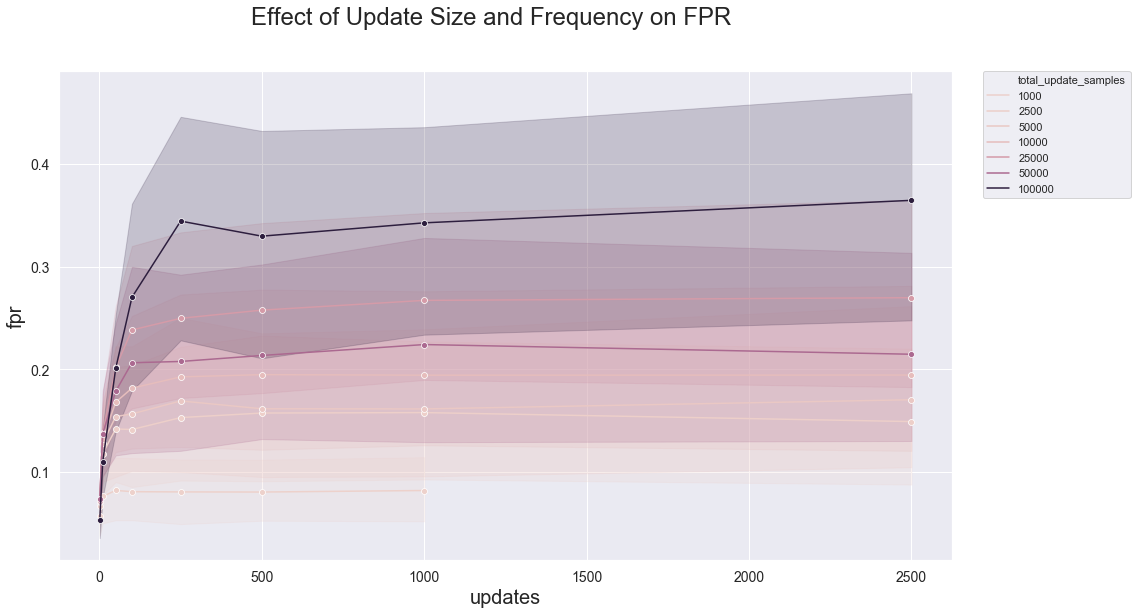

In [106]:
fig = plt.figure(figsize=(16,9))
fig.suptitle("Effect of Update Size and Frequency on FPR", fontsize=24)

ax = fig.add_subplot(111)
ax.set_ylabel("Max FPR", fontsize=20)
ax.set_xlabel("Num Updates", fontsize=20)

g = sns.lineplot(x="updates", y="fpr", hue="total_update_samples", data=data_coarse, legend="full", marker="o", ax=ax)

ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)
g.legend(loc='upper right',  ncol=1, bbox_to_anchor=(1.2, 1), borderaxespad=0.)
fig.show()

## Fine Intervals

Asymptotically, it's clear that in the worst case, more samples and more updates means worse FPR. However, now let's understand the smaller regime of updates to see if this asymptotic behaviour holds in this domain as well

In [100]:
seeds = 10
n_train = 10000
n_test = 50000
sizes = [1000, 2500, 5000, 10000, 25000, 50000, 100000]
updates = list(np.arange(0, 200, 5))[1:]

In [101]:
results_fine = train_update_loop(n_train, n_test, sizes, updates, seeds)

In [107]:
data_fine = summarize_fprs(results_fine, sizes, updates)

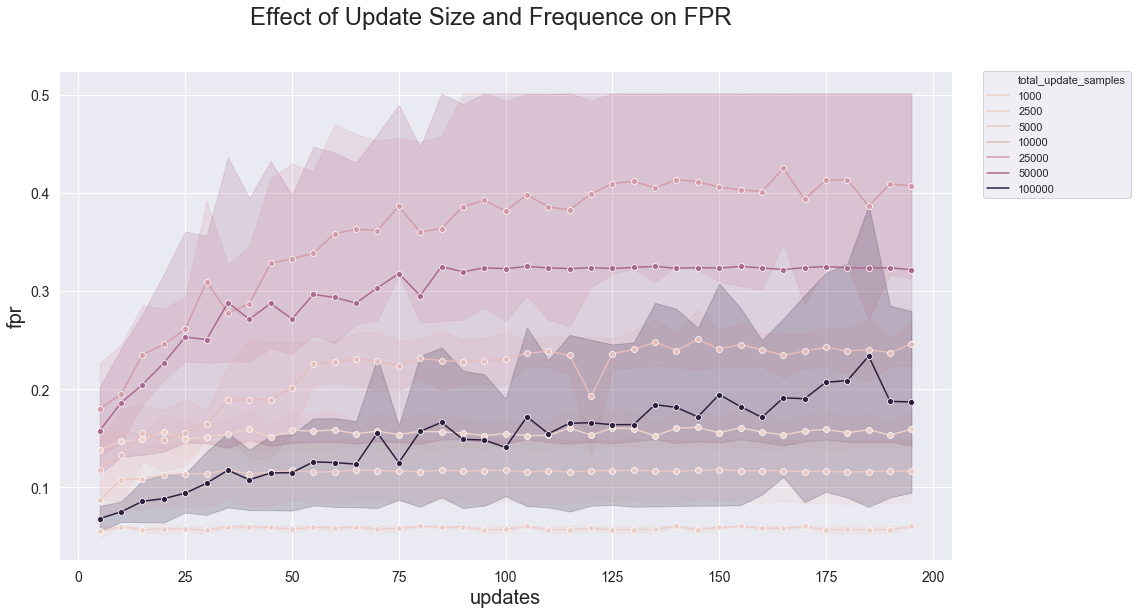

In [110]:
fig = plt.figure(figsize=(16,9))
fig.suptitle("Effect of Update Size and Frequence on FPR", fontsize=24)

ax = fig.add_subplot(111)
ax.set_ylabel("Max FPR", fontsize=20)
ax.set_xlabel("Num Updates", fontsize=20)

g = sns.lineplot(x="updates", y="fpr", hue="total_update_samples", legend="full", data=data_fine, marker="o", ax=ax)

ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)

g.legend(loc='upper right',  ncol=1, bbox_to_anchor=(1.2, 1), borderaxespad=0.)

fig.show()

## More Intuitive Plots

While the previous plots reveal an interesting relationship between FPR, update frequency, and update size, they are not intuitive. For example, the x-axis is labeled as number of updates, which suggests that each line represents a single model, and as more updates are done, the FPR gets worse. This is not the case as on a given line, each point corresponds to a different model updated with batch size #samples/#updates for #updates many iterations, so it's not correct to think of points on the same line as what happens when we train a given model with more updates. I.e. in the above plots, a point on line corresponding to 10,000 samples and 100 updates means that a model was updated on *all* the 10,000 samples with batch size of 10,000 / 100 = 100, but a point on the same line at 50 updates means a different model that was updated with *all* 10,000 samples, with batch size of 10,000 / 50 = 200

To address this issue, we have to modify our update_model_online_feedback() method to return the FPRs after each update iteration

In [211]:
seeds = 100
n_train = 10000
n_test = 50000
sizes = [1000, 2500, 5000, 10000, 25000, 50000, 100000]
updates = 500

In [212]:
def train_update_loop_intermediate(n_train, n_test, sizes, updates, seeds):
    seeds = np.arange(seeds)
    results = {size: [] for size in sizes}

    for seed in seeds:
        for size in sizes:
            np.random.seed(seed)

            x, y = make_classification(n_train + size + n_test, n_informative=2, n_features=2, n_classes=2, n_clusters_per_class=2 ,n_redundant=0, flip_y=0, class_sep=1.0)
            x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=size + n_test)
            x_update, x_test, y_update, y_test = train_test_split(x_test, y_test, test_size=n_test)

            model = linear_model.SGDClassifier(max_iter=10000, tol=1e-3, warm_start=True, loss="log")
            model.fit(x_train, y_train)

            y_pred = model.predict(x_test)
            initial_tnr, initial_fpr, initial_fnr, initial_tpr = eval_model(y_test, y_pred)

            new_model, rates = update_model_feedback(model, x_update, y_update, x_test, y_test, updates, intermediate=True)

            results[size].append(rates["fpr"])
                
    return results

In [ ]:
results_temporal_big = train_update_loop_intermediate(n_train, n_test, sizes, updates, seeds)

In [215]:
results_temporal = results_temporal_big

In [216]:
data_temporal = {"num_updates": [], "total_update_samples": [], "fpr": []}

for size in sizes:
    for i in range(seeds):
        data_temporal["fpr"] += results_temporal[size][i]
        data_temporal["total_update_samples"] += [size] * len(results_temporal[size][i])
        data_temporal["num_updates"] += (np.arange(updates) + 1).tolist()

In [217]:
data_temporal = pd.DataFrame(data_temporal)

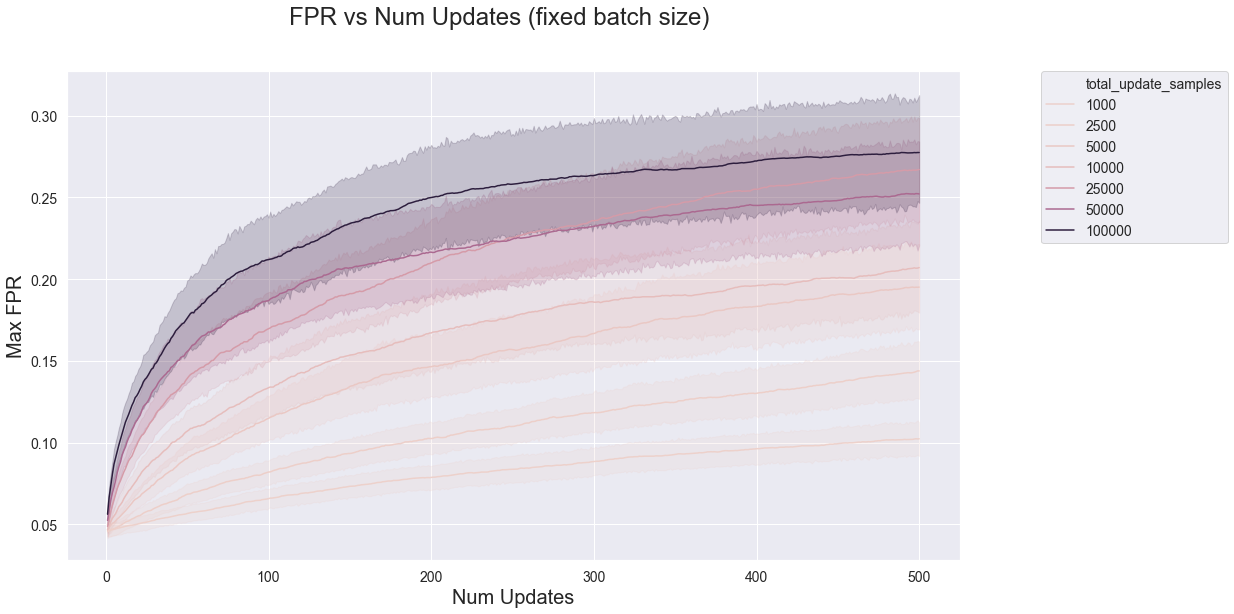

In [229]:
fig = plt.figure(figsize=(16,9))
fig.suptitle("FPR vs Num Updates (fixed batch size)", fontsize=24)

ax = fig.add_subplot(111)


g = sns.lineplot(x="num_updates", y="fpr", hue="total_update_samples", legend="full", data=data_temporal, ax=ax)
ax.set_ylabel("Max FPR", fontsize=20)
ax.set_xlabel("Num Updates", fontsize=20)

ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)

g.legend(loc='upper right',  ncol=1, bbox_to_anchor=(1.3, 1), borderaxespad=0., prop={'size':14})

fig.show()

## Function Fitting

It would be nice to have a general claim saying the previously plotted curves follow some analytic function. Here, we try to fit functions of the following form

$$f(x) = \frac{a}{e^{bx + c}} + d$$
$$f(x) = a + \frac{b}{x + c}$$
$$f(x) = \mathrm{log} (ax + b) + c$$

In [219]:
from scipy.optimize import curve_fit
from scipy.stats import linregress

In [220]:
def f1(x, a, b, c, d):
    return a / np.exp(-x * b + c) + d

In [221]:
def f2(x, a, b, c):
    return a + b / (x + c)

In [222]:
def f3(x, a, b, c, d):
    return a * np.log(b * x + c) + d

In [223]:
def f3_inv(y, a, b, c, d):
    return (np.exp((y - d) / a) - c) / b

In [224]:
def f4(x, a, b, c):
    return np.sqrt(a * x + b) + c

/h/alexadam/anaconda3/envs/dl/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  


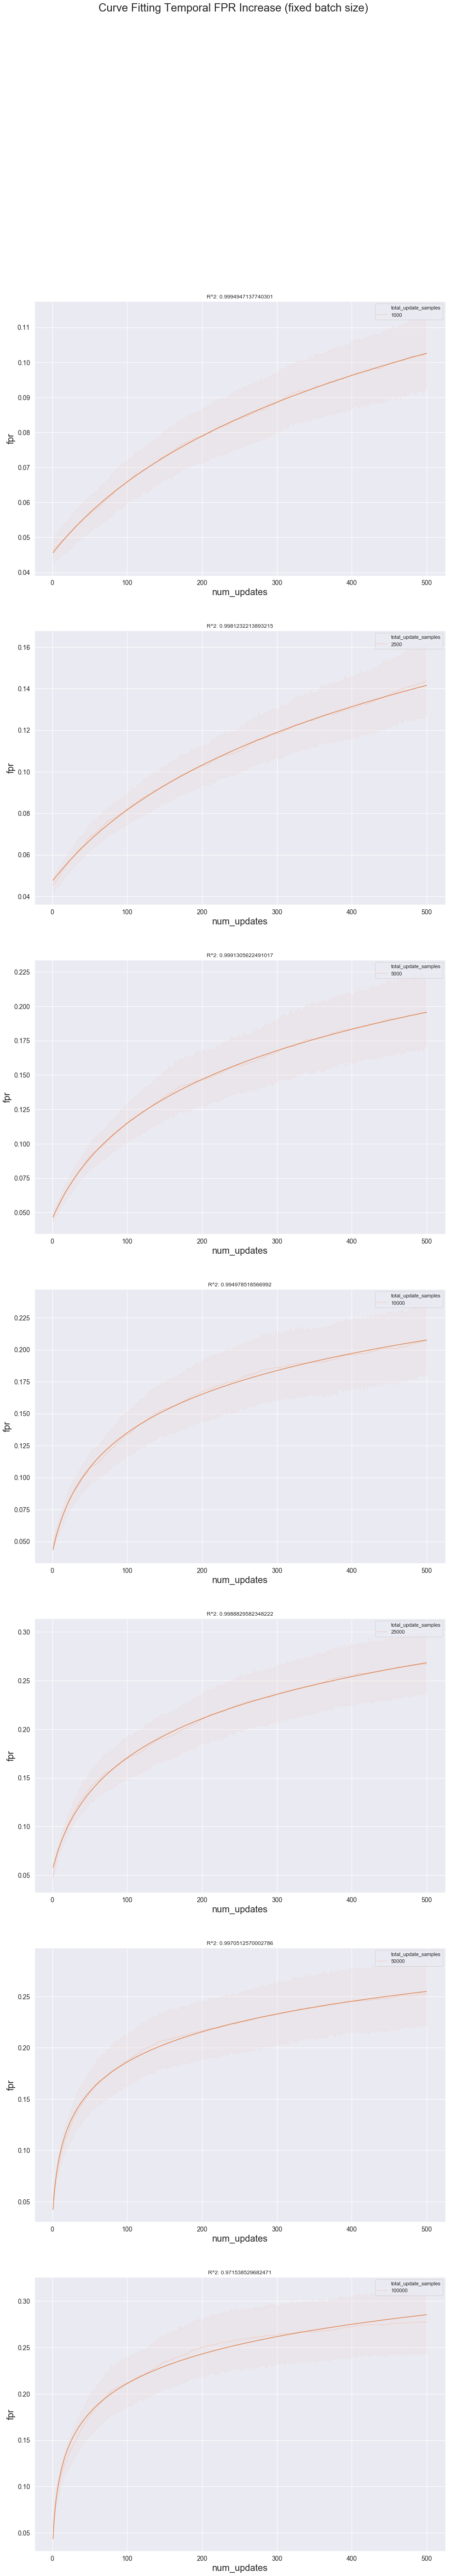

In [225]:
fig = plt.figure(figsize=(16,90))
fig.suptitle("Curve Fitting Temporal FPR Increase (fixed batch size)", fontsize=24)

for i, size in enumerate(sizes):
    ydata = np.mean(np.array(results_temporal[size]), 0)
    xdata = np.arange(updates) + 1
    
    popt, pcov = curve_fit(f3, xdata, ydata, maxfev=100000)
    fitted_y = f3(xdata, popt[0], popt[1], popt[2], popt[3])
    
    yinv = f3_inv(ydata, popt[0], popt[1], popt[2], popt[3])
    slope, intercept, r_value, p_value, std_err = linregress(xdata, yinv)
    

    ax = fig.add_subplot(len(sizes), 1, i + 1)
    ax.set_ylabel("Max FPR", fontsize=20)
    ax.set_xlabel("Num Updates", fontsize=20)
    ax.set_title("R^2: {}".format(r_value ** 2))

    g = sns.lineplot(x="num_updates", y="fpr", hue="total_update_samples", legend="full", data=data_temporal.loc[data_temporal["total_update_samples"] == size], ax=ax)
    sns.lineplot(x=xdata, y=fitted_y, ax=ax)

    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.tick_params(axis='both', which='minor', labelsize=14)

fig.show()

/h/alexadam/anaconda3/envs/dl/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  


In [199]:
popt

array([0.10208026, 0.03032036, 0.77907597, 0.06027588])

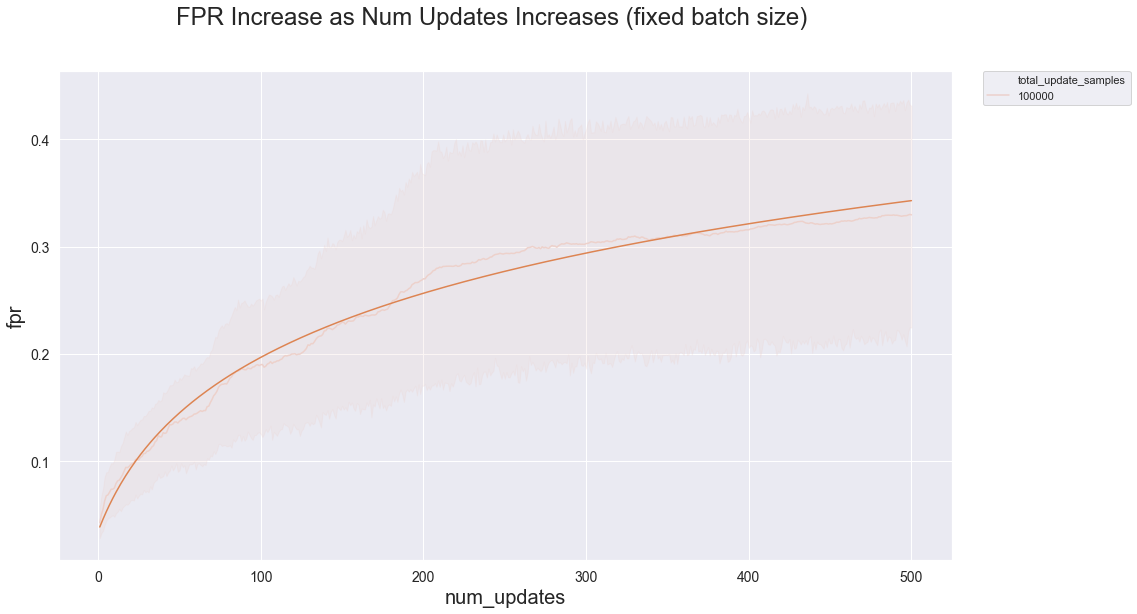